In [2]:
import gooseberry as gs
from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

(array([[-0.62724767,  0.66875419,  1.03705122],
       [-0.37271898,  1.56017543, -0.79737413],
       [-1.11845825, -0.60012825, -0.38870102]]), array([[ 0.42858014,  0.67712493, -0.34762683],
       [-0.33007962, -0.62588968, -0.12914992],
       [ 0.05418737, -0.85910359,  0.06395201]]), array([[2.44186157, 0.        , 0.        ],
       [0.        , 0.5574945 , 0.        ],
       [0.        , 0.        , 0.39171522]]), array([[ 1.62057728e+00,  3.88578059e-16,  8.32667268e-17],
       [ 3.88578059e-16,  1.62057728e+00, -7.49400542e-16],
       [ 8.32667268e-17, -7.49400542e-16,  1.62057728e+00]]))


In [3]:
class QQT_new:
    def __init__(self, init_w1, init_w2, X, Y, weights_only=False):
        
        self.weights_only = weights_only
        self.batch_size = X.shape[0]

        self.input_dim = X.shape[1]
        self.output_dim = Y.shape[1]
        
        sigma_yx_tilde = 1 / self.batch_size * Y.T @ X 

        U_, S_, Vt_= np.linalg.svd(sigma_yx_tilde)
        V_ = Vt_.T 

        self.dim_diff = np.abs(self.input_dim - self.output_dim)

        if self.input_dim < self.output_dim:
            U_hat = U_[:, self.input_dim:]
            V_hat = np.zeros((self.input_dim, self.dim_diff))
            U_ = U_[:, :self.output_dim]

        elif self.input_dim > self.output_dim:
            U_hat = np.zeros((self.output_dim, self.dim_diff))
            V_hat = V_[:, self.output_dim:]
            V_ = V_[:, :self.output_dim]

        else:
            U_hat  = None 
            V_hat = None

        self.U_hat = U_hat 
        self.V_hat = V_hat 
        self.U_, self.S_, self.V_ = U_, np.diag(S_), V_

        U, S, Vt  = np.linalg.svd(init_w2 @ init_w1, full_matrices=False)
        self.U, self.S, self.V = U, S, Vt.T 

        self.B = self.U.T @ self.U_ + self.V.T @ self.V_ 
        self.C = self.U.T @ self.U_ - self.V.T @ self.V_



        ##CHECK THAT B IS NON SINGULAR
        self.t = 0

    def forward(self, learning_rate):
        #performs forward for one timestep

        time_step = self.t * learning_rate

        i = np.identity(self.input_dim) if self.input_dim < self.output_dim else np.identity(self.output_dim) 

        e_st_inv = np.diag(np.exp(-1. * np.diag(self.S_) * time_step))
        e_2st_inv = np.diag(np.exp(-2. * np.diag(self.S_) * time_step))

        B_inv = np.linalg.inv(self.B)

        Sinv = np.diag(1. / self.S)
        S_inv = np.diag(1. / np.diag(self.S_))

        # if self.t==10:
        #     print('QQT changed version:')
        #     print('V_: ', self.V_)
        #     print('U_: ', self.U_)
        #     print('e_st_inv: ', e_st_inv)
        #     print('C: ', self.C)
        #     print('B_inv: ', B_inv)
        #     print('V_hat: ', self.V_hat)
        #     print('V:  ', self.V)
        #     print('U_hat: ', self.U_hat)
        #     print('U:  ', self.U)

        if self.U_hat is None and self.V_hat is None:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv),
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv)
            ])
            center_right = 0.

        else:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.V_hat@self.V_hat.T @ self.V @ B_inv.T @ e_st_inv,
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.U_hat@self.U_hat.T @ self.U @ B_inv.T @ e_st_inv
            ])
            center_right = 4 * time_step * e_st_inv @ B_inv @ (self.V.T @ self.V_hat @ self.V_hat.T @ self.V + self.U.T @ self.U_hat @ self.U_hat.T @ self.U) @ B_inv.T @ e_st_inv

        center_left = 4. * e_st_inv @ B_inv @ Sinv @ B_inv.T @ e_st_inv 
        center_center = (i - e_2st_inv) @ S_inv- e_st_inv @ B_inv @ self.C @ (e_2st_inv - i) @ S_inv @ self.C.T @ B_inv.T @ e_st_inv
        
        # if self.t==1:
        #     print('New Version center_center variables: ')
        #     print('i: ', i)
        #     print('e_2st_inv: ', e_2st_inv)
        #     print('S_inv: ', S_inv)
        #     print('e_st_inv: ', e_st_inv)
        #     print('B_inv: ', B_inv)
        #     print('C: ', self.C)

        center = np.linalg.inv(center_left + center_center + center_right)

        qqt = Z @ center @ Z.T 
        if self.weights_only:
            qqt = qqt[self.input_dim:, :self.input_dim] 

        self.t+=1
        return qqt 

In [11]:
import torch
import torch.nn as nn 
import torch.optim as optim

import matplotlib.pyplot as plt 
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import seaborn as sns
from tools import BlindColours, zero_balanced_weights


In [12]:
#THE NETWORK'S WEIGHTS ARE OPTIMISED WITH FULL BATCH GRADIENT DESCEINT WITH LEARNING RATE TAU

class LinearNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, init_w1=None, init_w2=None):
        super(LinearNetwork, self).__init__()
        self.first_layer = nn.Linear(in_dim, hidden_dim)
        self.second_layer = nn.Linear(hidden_dim , out_dim)

        if init_w1 is not None:
            self.first_layer.weight.data = init_w1.float()
        if init_w2 is not None:
            self.second_layer.weight.data = init_w2.float()

    def forward(self, x):
        x = self.first_layer(x)
        x = self.second_layer(x)
        return x 
    

def train(model, X_train, y_train, criterion, optimizer, epochs):
    
    w_ones = [model.first_layer.weight.data.clone()]
    w_twos = [model.second_layer.weight.data.clone()]
    losses = []

    for epoch in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        w_ones.append(model.first_layer.weight.data.clone().numpy())
        w_twos.append(model.second_layer.weight.data.clone().numpy())
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    
    w_ones = np.array(w_ones)
    w_twos = np.array(w_twos)
    losses = np.array(losses)

    return w_ones, w_twos, losses


def whiten(X):

    scaler = StandardScaler()
    X_standardised = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_standardised)

    X_whitened = torch.tensor(X_pca / np.sqrt(pca.explained_variance_), dtype=torch.float32)

    return X_whitened

def get_random_regression_task(batch_size, in_dim, out_dim):
    X = torch.randn(batch_size, in_dim)
    Y = torch.randn(batch_size, out_dim)
    X_whitened = whiten(X)

    return X_whitened, Y

TypeError: len() of unsized object

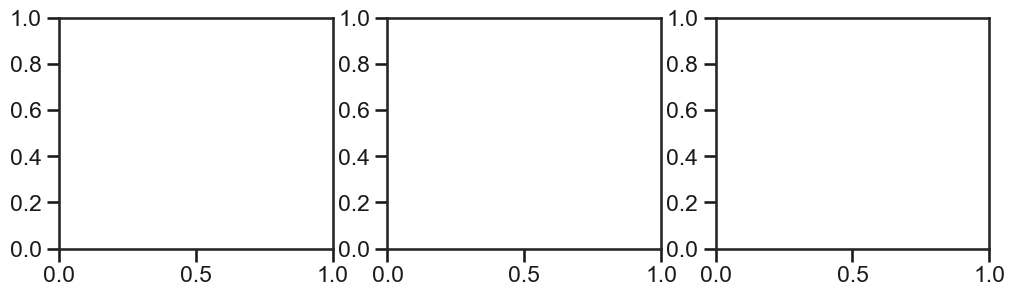

In [21]:
np.random.seed(1)

in_dim = 5
hidden_dim = 10
out_dim = 2

batch_size = 10
learning_rate = 0.1
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])

    
    X, Y = train(None)

    init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)
    model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    w1s, w2s, losses = train(model, torch.tensor(X), torch.tensor(Y), criterion, optimizer, training_steps)

    analytical = np.asarray([w2 @ w1 for (w2, w1) in zip(w2s, w1s)])


    # analytical = QQT_new(init_w1, init_w2, X, Y, True)
    # analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")



without tensor: 
init_w1:  tensor([[-0.0138,  0.0003, -0.0059, -0.0034, -0.0246],
        [-0.0092,  0.0141,  0.0023,  0.0006,  0.0100],
        [ 0.0121,  0.0195,  0.0058,  0.0125, -0.0043],
        [-0.0002,  0.0018, -0.0106,  0.0027, -0.0181],
        [-0.0087,  0.0056,  0.0089, -0.0029,  0.0153],
        [ 0.0050, -0.0122, -0.0040, -0.0282,  0.0006],
        [ 0.0059,  0.0085, -0.0030,  0.0027,  0.0102],
        [-0.0033, -0.0016,  0.0081,  0.0084, -0.0185],
        [ 0.0050,  0.0017, -0.0094, -0.0017, -0.0035],
        [ 0.0021, -0.0033, -0.0020,  0.0059, -0.0005]], dtype=torch.float64)
init_w2:  tensor([[-0.0054, -0.0089,  0.0108,  0.0070, -0.0127,  0.0068,  0.0056, -0.0039,
          0.0090,  0.0017],
        [-0.0052,  0.0074,  0.0216,  0.0014,  0.0012, -0.0303,  0.0069,  0.0064,
         -0.0014,  0.0034],
        [-0.0244, -0.0020, -0.0008, -0.0173,  0.0080,  0.0024,  0.0041, -0.0069,
         -0.0059,  0.0013],
        [ 0.0026, -0.0105, -0.0116,  0.0058, -0.0097, -0.0031, -

/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_42578/872467563.py:248: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)


without tensor: 
init_w1:  tensor([[ 0.0203,  0.2994,  0.2578, -0.1388, -0.0311],
        [ 0.4401,  0.4534, -0.3973, -0.2327,  0.2696],
        [ 0.2505, -0.2265,  0.0833,  0.1943,  0.0884],
        [ 0.1251, -0.1318,  0.0025,  0.2653, -0.1509],
        [-0.2409,  0.0582,  0.1179, -0.1019, -0.3873],
        [ 0.3010, -0.0301, -0.0335,  0.0878,  0.1198],
        [ 0.0784,  0.0342, -0.2787, -0.0903, -0.3214],
        [-0.0081,  0.2933,  0.1806, -0.2850,  0.0036],
        [-0.0329, -0.2889, -0.1957,  0.0071, -0.4226],
        [-0.1596,  0.2002,  0.1242, -0.1013,  0.4156]], dtype=torch.float64)
init_w2:  tensor([[ 3.3551e-01,  3.9213e-01, -3.9298e-02, -6.4200e-02,  5.9457e-02,
          8.9470e-02,  6.7451e-02,  3.3349e-01, -1.6169e-01,  7.8875e-03],
        [ 5.0255e-02,  5.4792e-01, -1.1352e-01, -2.7290e-01, -2.7938e-01,
          4.8136e-02, -1.4081e-01,  1.5454e-01, -3.8504e-01,  4.1599e-01],
        [ 3.0570e-04, -2.8331e-01,  2.4552e-01,  1.5040e-03, -1.5280e-01,
          9.4634e-0

/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_42578/872467563.py:248: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)
/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_42578/872467563.py:248: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)


Epoch [200/400], Loss: 0.0039
Epoch [210/400], Loss: 0.0039
Epoch [220/400], Loss: 0.0039
Epoch [230/400], Loss: 0.0038
Epoch [240/400], Loss: 0.0038
Epoch [250/400], Loss: 0.0038
Epoch [260/400], Loss: 0.0038
Epoch [270/400], Loss: 0.0037
Epoch [280/400], Loss: 0.0037
Epoch [290/400], Loss: 0.0037
Epoch [300/400], Loss: 0.0037
Epoch [310/400], Loss: 0.0037
Epoch [320/400], Loss: 0.0037
Epoch [330/400], Loss: 0.0036
Epoch [340/400], Loss: 0.0036
Epoch [350/400], Loss: 0.0036
Epoch [360/400], Loss: 0.0036
Epoch [370/400], Loss: 0.0036
Epoch [380/400], Loss: 0.0036
Epoch [390/400], Loss: 0.0035
Epoch [400/400], Loss: 0.0035


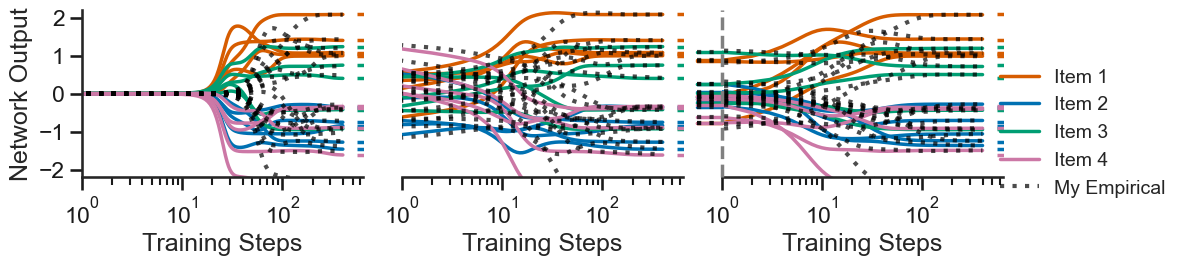

In [38]:
import gooseberry as gs
from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn 
import torch.optim as optim

import matplotlib.pyplot as plt 
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import seaborn as sns
from tools import BlindColours, zero_balanced_weights


class QQT_new:
    def __init__(self, init_w1, init_w2, X, Y, weights_only=False):
        
        self.weights_only = weights_only
        self.batch_size = X.shape[0]

        self.input_dim = X.shape[1]
        self.output_dim = Y.shape[1]
        
        sigma_yx_tilde = 1 / self.batch_size * Y.T @ X 

        U_, S_, Vt_= np.linalg.svd(sigma_yx_tilde)
        V_ = Vt_.T 

        self.dim_diff = np.abs(self.input_dim - self.output_dim)

        if self.input_dim < self.output_dim:
            U_hat = U_[:, self.input_dim:]
            V_hat = np.zeros((self.input_dim, self.dim_diff))
            U_ = U_[:, :self.output_dim]

        elif self.input_dim > self.output_dim:
            U_hat = np.zeros((self.output_dim, self.dim_diff))
            V_hat = V_[:, self.output_dim:]
            V_ = V_[:, :self.output_dim]

        else:
            U_hat  = None 
            V_hat = None

        self.U_hat = U_hat 
        self.V_hat = V_hat 
        self.U_, self.S_, self.V_ = U_, np.diag(S_), V_

        U, S, Vt  = np.linalg.svd(init_w2 @ init_w1, full_matrices=False)
        self.U, self.S, self.V = U, S, Vt.T 

        self.B = self.U.T @ self.U_ + self.V.T @ self.V_ 
        self.C = self.U.T @ self.U_ - self.V.T @ self.V_



        ##CHECK THAT B IS NON SINGULAR
        self.t = 0

    def forward(self, learning_rate):
        #performs forward for one timestep

        time_step = self.t * learning_rate

        i = np.identity(self.input_dim) if self.input_dim < self.output_dim else np.identity(self.output_dim) 

        e_st_inv = np.diag(np.exp(-1. * np.diag(self.S_) * time_step))
        e_2st_inv = np.diag(np.exp(-2. * np.diag(self.S_) * time_step))

        B_inv = np.linalg.inv(self.B)

        Sinv = np.diag(1. / self.S)
        S_inv = np.diag(1. / np.diag(self.S_))

        # if self.t==10:
        #     print('QQT changed version:')
        #     print('V_: ', self.V_)
        #     print('U_: ', self.U_)
        #     print('e_st_inv: ', e_st_inv)
        #     print('C: ', self.C)
        #     print('B_inv: ', B_inv)
        #     print('V_hat: ', self.V_hat)
        #     print('V:  ', self.V)
        #     print('U_hat: ', self.U_hat)
        #     print('U:  ', self.U)

        if self.U_hat is None and self.V_hat is None:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv),
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv)
            ])
            center_right = 0.

        else:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.V_hat@self.V_hat.T @ self.V @ B_inv.T @ e_st_inv,
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.U_hat@self.U_hat.T @ self.U @ B_inv.T @ e_st_inv
            ])
            center_right = 4 * time_step * e_st_inv @ B_inv @ (self.V.T @ self.V_hat @ self.V_hat.T @ self.V + self.U.T @ self.U_hat @ self.U_hat.T @ self.U) @ B_inv.T @ e_st_inv

        center_left = 4. * e_st_inv @ B_inv @ Sinv @ B_inv.T @ e_st_inv 
        center_center = (i - e_2st_inv) @ S_inv- e_st_inv @ B_inv @ self.C @ (e_2st_inv - i) @ S_inv @ self.C.T @ B_inv.T @ e_st_inv
        
        # if self.t==1:
        #     print('New Version center_center variables: ')
        #     print('i: ', i)
        #     print('e_2st_inv: ', e_2st_inv)
        #     print('S_inv: ', S_inv)
        #     print('e_st_inv: ', e_st_inv)
        #     print('B_inv: ', B_inv)
        #     print('C: ', self.C)

        center = np.linalg.inv(center_left + center_center + center_right)

        qqt = Z @ center @ Z.T 
        if self.weights_only:
            qqt = qqt[self.input_dim:, :self.input_dim] 

        self.t+=1
        return qqt 
    

#THE NETWORK'S WEIGHTS ARE OPTIMISED WITH FULL BATCH GRADIENT DESCEINT WITH LEARNING RATE TAU

class LinearNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, init_w1=None, init_w2=None):
        super(LinearNetwork, self).__init__()
        self.first_layer = nn.Linear(in_dim, hidden_dim)
        self.second_layer = nn.Linear(hidden_dim , out_dim)

        if init_w1 is not None:
            self.first_layer.weight.data = init_w1.float()
        if init_w2 is not None:
            self.second_layer.weight.data = init_w2.float()

    def forward(self, x):
        x = self.first_layer(x)
        x = self.second_layer(x)
        return x 
    

def train(model, X_train, y_train, criterion, optimizer, epochs):
    
    w_ones = [model.first_layer.weight.data.clone()]
    w_twos = [model.second_layer.weight.data.clone()]
    print('init_w1 training: ', w_ones[0])
    print('init_w2 training: ', w_twos[0])
    losses = []

    for epoch in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        w_ones.append(model.first_layer.weight.data.clone().numpy())
        w_twos.append(model.second_layer.weight.data.clone().numpy())
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    
    w_ones = np.array(w_ones)
    w_twos = np.array(w_twos)
    losses = np.array(losses)

    return w_ones, w_twos, losses


def whiten(X):

    scaler = StandardScaler()
    X_standardised = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_standardised)

    X_whitened = torch.tensor(X_pca / np.sqrt(pca.explained_variance_), dtype=torch.float32)

    return X_whitened

def get_random_regression_task(batch_size, in_dim, out_dim):
    X = torch.randn(batch_size, in_dim)
    Y = torch.randn(batch_size, out_dim)
    X_whitened = whiten(X)

    return X_whitened, Y


np.random.seed(1)

in_dim = 5
hidden_dim = 10
out_dim = 5

batch_size = 10
learning_rate = 0.1
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
train_data, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])

    
    X, Y = train_data(None)

    print('without tensor: ')
    print('init_w1: ', init_w1)
    print('init_w2: ', init_w2)
    init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)
    print('with tensor: ')
    print('init_w1: ', init_w1)
    print('init_w2: ', init_w2)

    model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    w1s, w2s, losses = train(model, torch.tensor(np.array(X)), torch.tensor(np.array(Y)), criterion, optimizer, training_steps)

    analytical = np.asarray([w2 @ w1 for (w2, w1) in zip(w2s, w1s)])


    # analytical = QQT_new(init_w1, init_w2, X, Y, True)
    # analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical[:-1] @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="My Empirical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")

